# Executive Summary

I'm using the environment in the OpenAI gym - MuJoCo to practice how to train an agent by reinforcement learning. In this notebook, ***The goal is make a three-dimensional bipedal robot walk forward as fast as possible, without falling over***

***Found Project Baseline by Using Random Action*** (Section 4)
- by only taken random actions ***The robot falling over quickly***. At the end of each episode score receive between 83 to 145 (average 112). 

Try ***Epsilon-Greedy Policy*** to complete this goal (Section 5 & 6)
- The ***Agent with Epsilon-Greedy Policy stop learning process at epoch #201 with average reward 1014***
- Time spend on receiving more than 1000 average reward 40min

### ***Table of Content:***
1. What is Humanoid
2. Import Dependencies
3. Understanding The Environment
4. Found Project Baseline by Using Random Action
5. Epsilon-Greedy Policy
6. Q-learning via Gradient Descent
7. Video Record and Play the Final Performance

# 1. What is Humanoid-v2

<img src='http://gym.openai.com/videos/2019-10-21--mqt8Qj1mwo/Humanoid-v2/poster.jpg' width='250px'/>

***Goal***
- ***Make a three-dimensional bipedal robot walk forward as fast as possible, without falling over***.

***Action Space***
- Actions are ***motor speed values in the [-1, 1] range for each of the 4 joints at both hips and knees***.

***Observation Space***
- State consists of ***hull angle speed, angular velocity, horizontal speed, vertical speed, position of joints and joints angular speed, legs contact with ground, and 10 lidar rangefinder measurements***. 
- There are no coordinates in the state vector.

***Rewards***
- total ***300+ points up to the far end***
- If the ***robot falls, it gets -100*** 
- ***Applying motor torque costs a small amount of points***. A more optimal agent will get a better score.

***Starting State***
- The walker ***starts standing at the left end of the terrain with the hull horizontal, and both legs in the same position with a slight knee angle***.

***Episode Termination***
- The episode will terminate ***if the hull gets in contact with the ground*** or ***if the walker exceeds the right end of the terrain length***.

# 2. Import Dependencies

objc[2799]: Class GLFWApplicationDelegate is implemented in both /Users/hoikinyu/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1026cc778) and /Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x102b8a7c0). One of the two will be used. Which one is undefined.
objc[2799]: Class GLFWWindowDelegate is implemented in both /Users/hoikinyu/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1026cc700) and /Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x102b8a7e8). One of the two will be used. Which one is undefined.
objc[2799]: Class GLFWContentView is implemented in both /Users/hoikinyu/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1026cc7a0) and /Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x102b8a838). One of the two will be used. Which one is undefined.
objc[2799]: Class GLFWWindow is implemented in both /Users/hoikinyu/.mujoco/mujoco200/bin/libglfw.3.dylib (0x1026cc818) and /Users/hoikinyu/opt/anaconda3/lib/pyt

Creating offscreen glfw


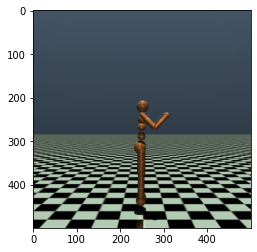

In [1]:
import mujoco_py
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('Humanoid-v2')                          # Using Humanoid verion 2 in this notebook
env.reset()                                            # reset the environment to initial default

plt.imshow(env.render('rgb_array'))                    # display the environment

# 3. Understanding The Environment

In [2]:
state = env.reset()

print("There are %d states in observation:" % len(state), state)

There are 376 states in observation: [ 1.39835464e+00  9.99897904e-01  8.33534972e-03 -6.31522170e-03
 -9.73765830e-03  5.14282902e-04  5.71116305e-03  5.86796257e-03
  9.54588231e-03  8.00482698e-03  5.19514082e-03 -7.60270132e-03
  7.36539653e-03  4.93809530e-03  9.04817394e-03  4.99224399e-03
 -5.49564292e-04  4.31489618e-03 -1.14961863e-03 -9.93567626e-03
  5.31635540e-03  8.47229667e-03  7.68318641e-03  8.10265661e-04
 -1.81552572e-03  2.17565903e-04  3.81386369e-03 -1.55348072e-03
  5.50981434e-03 -5.05516655e-04  3.96664108e-03 -3.28439216e-03
 -9.78728934e-03  8.62720952e-03  9.07179165e-04 -6.83964376e-03
 -5.80088744e-03  7.14630652e-03 -9.44285641e-03 -3.89966899e-03
 -7.13115388e-03 -2.96423727e-03 -1.10883950e-03  8.27297864e-03
 -4.02664388e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.22913342e+00
  2.22069081e+00  3.78033589e-02 -1.91606339e-03  8.7

In [3]:
action = env.action_space.sample()

print("There are %d motor speed values in the range [-1, 1]:" % len(action), action)

There are 17 motor speed values in the range [-1, 1]: [ 0.14853771 -0.18502122  0.25002658 -0.25788018 -0.2815626  -0.3490387
  0.27014658  0.22218801 -0.29725266  0.10548491  0.01224396  0.26011857
  0.2869393   0.20644006  0.3915436  -0.03753963 -0.10023277]


# 4. Found Project Baseline by Using Random Action

In [4]:
%%time
episodes = 5

for episode in range(1, episodes + 1):                     # looping from 1 to 5
    
    state = env.reset()                                    # initial the set of observation
    
    done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment
    
    score = 0                                              # running score counter
    
    timesteps_counter = 0                                  # count the number of timestep spend
    
    while not done:
        
        env.render()                                       # view the graphical representation that environment
        
        action = env.action_space.sample()                 # random choose an action 
        
        new_state, reward, done, info = env.step(action)   # pass random actions into environment to get back
                                                            # 1. next set of observation
                                                            # 2. reward
                                                            # 3. done (episode is done = True)
        
        score += reward                                    # accumulate each episodes' reward received into score
        
        state = new_state                                  # update state
        
        timesteps_counter += 1                             # +1 in each timestep spend
        
    print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

Creating window glfw
Episode:1 Score:108.10663695570818 Timesteps Spend:21
Episode:2 Score:90.40527340967199 Timesteps Spend:18
Episode:3 Score:83.18658496165897 Timesteps Spend:17
Episode:4 Score:145.85160625792338 Timesteps Spend:31
Episode:5 Score:136.80650541206626 Timesteps Spend:27
CPU times: user 237 ms, sys: 78.4 ms, total: 315 ms
Wall time: 482 ms


Remark: 
- The above 5 episode showing that, by taken random actions ***The robot falling over quickly***. At the end of each episode score receive between 83 to 145 (average 112). 

# 5. Epsilon-Greedy Policy

Pass current state info into the function epsilon_greedy_policy, if random number is:
- greater than epsilon: then the Agent will choice to take an action with maximum q_values.
- less than epsilon: then the Agent will choice to take an random action.

In [5]:
# Import Dependencies
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras
import keras.layers as L

tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

# Set the input_shape of the build_model function
num_states = env.observation_space.shape               # return number of observation space

# Set the output_shape of the build_model function
num_actions = env.action_space.shape[0]                     # use .n to return number of action

Instructions for updating:
non-resource variables are not supported in the long term


2022-03-29 21:55:10.838448: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
def build_network(states, actions):
    
    network = Sequential()
    
    network.add(Flatten(input_shape = (num_states), name = 'States'))        # use Flatten layer as the input layer, input_shape = number of state 
    
    network.add(Dense(128, activation = 'relu', name = 'Dense_1'))           # use Dense layer with 128 units of tensor with relu activation function
    
    network.add(Dense(64, activation = 'relu', name = 'Dense_2'))            # use another Dense layer with 64 units of tensor with relu activation function
    
    network.add(Dense(num_actions, activation = 'linear', name = 'Actions')) # the output layer with shape = number of actions with linear activation function
                                                                              # Output the probability for each actions
    return network

In [7]:
import random 

def epsilon_greedy_policy(state, epsilon=0):
    
    q_values = network.predict(state[None])[0]              # q_values V(s): the probability for each action, shape=[None]: size not fixed

    action = np.random.choice(num_actions)                  # randomly pick an action
    
    # Choose the max of q values if a random number id greater than epsilon else action
    if random.random() > epsilon:                           # if a random number > epsilon
    
        chosen_action = np.argmax(q_values)                 # output action with highest q_values
    
    else:                                                   # if a random number < epsilon
    
        chosen_action = action                              # output a random action
        
    return chosen_action                                    # output an action by epsilon_greedy_policy

# 6. Q-learning via Gradient Descent

In [8]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

actions_ph = keras.backend.placeholder(dtype='int32', shape=[None])

rewards_ph = keras.backend.placeholder(dtype='float32', shape=[None])

next_states_ph = keras.backend.placeholder(dtype='float32', shape=(None,) + env.observation_space.shape)

is_done_ph = keras.backend.placeholder(dtype='bool', shape=[None])

In [9]:
# run the build_network function
network = build_network(num_states, num_actions) 

network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
States (Flatten)             (None, 376)               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 128)               48256     
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
Actions (Dense)              (None, 17)                1105      
Total params: 57,617
Trainable params: 57,617
Non-trainable params: 0
_________________________________________________________________


### Compute Q-Values in Current State

In [10]:
# get q-values for all actions in current states
predicted_qvalues = network(states_ph)                    # Output the probability for each actions from network

# select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, env.action_space.shape[0]), axis=1)

### Predict Q-Values for Next State

In [11]:
# set reward discount factor gamma 
gamma = 0.99

# compute q-values for all actions in next states
predicted_next_qvalues = network(next_states_ph)                 

# compute V*(next_states) using predicted next q-values
next_state_values = tf.reduce_max(predicted_next_qvalues,1)         

# compute "target q-values" for loss. Also call: TD Target
target_qvalues_for_actions = rewards_ph + gamma * next_state_values 

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)    # is_done_ph: to check is the last state or not

### Compute Loss and Training Function

when doing gradient descent, __we won't propagate gradients through it__ to make training more stable.

To do so, we shall use `tf.stop_gradient` function which basically says ***"consider this thing constant when doingbackprop"***.

In [12]:
# mean squared error loss to minimize (predicted_qvalue - target_qvalue)
loss = (predicted_qvalues_for_actions - tf.stop_gradient(target_qvalues_for_actions)) ** 2

loss = tf.reduce_mean(loss)                                       # reduce_mean = sum of all loss / number of loss

# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [13]:
sess.run(tf.global_variables_initializer())

# define session
def generate_session(env, episode_max=1000, epsilon=0, train=False):
    
    total_reward = 0                                               # initial reward = 0
    
    state = env.reset()                                            # initialize the environment
    
    for episode in range(episode_max):
        
        action = epsilon_greedy_policy(state, epsilon=epsilon)     # chose an action by epsilon_greedy_policy
        
        next_state, reward, done, _ = env.step(action)             # the environment's feedback in terms of next_state, reward, is epsilon done
        
        if train:                                                  
            sess.run(train_step,                                   # agent.update(state, action, reward, next_state) from tabular agent
                     { 
                        states_ph: [state], 
                        actions_ph: [action], 
                        rewards_ph: [reward], 
                        next_states_ph: [next_state], 
                        is_done_ph: [done]
            })

        total_reward += reward                                     # update total_reward
        
        state = next_state                                         # update state
        
        if done:
            break
            
    return total_reward

In [14]:
%%time
# set epsilon: the probability for the Agent choice to take an random action when less than epsilon
epsilon = 0.5                  # initialze epsilon

for i in range(500):                                                                 # number of epoch to run
    
    for _ in range(100):                                                             # number of session to run
        
        session_rewards = generate_session(env, epsilon=epsilon, train=True)         # Train the agent
        
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99                                                                  # decrease epsilon per epoch mean less explortation over time
    
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"    # epsilon should be always nonzero 
    
    if np.mean(session_rewards) > 1000:                                               # session terminate if session_rewards > -85 
        
        print("Learning Completed!")
        
        break

/Users/hoikinyu/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


epoch #0	mean reward = 272.013	epsilon = 0.500
epoch #1	mean reward = 268.543	epsilon = 0.495
epoch #2	mean reward = 251.853	epsilon = 0.490
epoch #3	mean reward = 255.960	epsilon = 0.485
epoch #4	mean reward = 251.149	epsilon = 0.480
epoch #5	mean reward = 284.433	epsilon = 0.475
epoch #6	mean reward = 262.451	epsilon = 0.471
epoch #7	mean reward = 257.272	epsilon = 0.466
epoch #8	mean reward = 252.277	epsilon = 0.461
epoch #9	mean reward = 256.939	epsilon = 0.457
epoch #10	mean reward = 261.210	epsilon = 0.452
epoch #11	mean reward = 261.928	epsilon = 0.448
epoch #12	mean reward = 240.001	epsilon = 0.443
epoch #13	mean reward = 249.843	epsilon = 0.439
epoch #14	mean reward = 250.553	epsilon = 0.434
epoch #15	mean reward = 251.621	epsilon = 0.430
epoch #16	mean reward = 250.495	epsilon = 0.426
epoch #17	mean reward = 261.932	epsilon = 0.421
epoch #18	mean reward = 241.054	epsilon = 0.417
epoch #19	mean reward = 267.710	epsilon = 0.413
epoch #20	mean reward = 266.507	epsilon = 0.409
ep

epoch #170	mean reward = 513.386	epsilon = 0.091
epoch #171	mean reward = 327.194	epsilon = 0.090
epoch #172	mean reward = 599.619	epsilon = 0.089
epoch #173	mean reward = 329.157	epsilon = 0.088
epoch #174	mean reward = 637.561	epsilon = 0.087
epoch #175	mean reward = 314.441	epsilon = 0.086
epoch #176	mean reward = 484.566	epsilon = 0.085
epoch #177	mean reward = 331.772	epsilon = 0.084
epoch #178	mean reward = 678.402	epsilon = 0.084
epoch #179	mean reward = 498.676	epsilon = 0.083
epoch #180	mean reward = 279.316	epsilon = 0.082
epoch #181	mean reward = 741.940	epsilon = 0.081
epoch #182	mean reward = 673.825	epsilon = 0.080
epoch #183	mean reward = 633.950	epsilon = 0.079
epoch #184	mean reward = 462.323	epsilon = 0.079
epoch #185	mean reward = 323.740	epsilon = 0.078
epoch #186	mean reward = 261.537	epsilon = 0.077
epoch #187	mean reward = 300.751	epsilon = 0.076
epoch #188	mean reward = 324.803	epsilon = 0.076
epoch #189	mean reward = 432.007	epsilon = 0.075
epoch #190	mean rewa

Remark: 
- The ***Agent with Epsilon-Greedy Policy stop learning process at epoch #201 with average reward 1014***
- Time spend on receiving more than 1000 average reward 40min

In [15]:
# Save the agent
save_path = os.path.join('Training', 'Saved Models', 'Epsilon_Greedy_Policy_Network_Humanoid-v2')

network.save(save_path)

# 7. Video Record and Play the Final Performance

In [22]:
sess.run(tf.global_variables_initializer())

def generate_final_session(env):
    
    # Test the agent
    episodes = 5

    for episode in range(1, episodes + 1):                     # looping from 1 to 5

        obs = env.reset()                                      # initial the set of observation

        done = False                                           # initial the game is over = False, until reach maximum number of steps in this particular environment

        score = 0                                              # running score counter

        timesteps_counter = 0                                  # count the number of timestep spend

        while not done:

            env.render()                                       # view the graphical representation that environment

            action_values = network.predict(obs[None])         # use the network learned by epsilon_greedy_policy to calculate action_values of all possible actions         

            chosen_action = np.argmax(action_values)           # choose action with highest action_values 

            obs, reward, done, info = env.step(chosen_action) # pass random actions into environment to get back
                                                                # 1. next set of observation
                                                                # 2. reward
                                                                # 3. done (episode is done = True)

            score += reward                                    # accumulate each episodes' reward received into score

            timesteps_counter += 1                             # +1 in each timestep spend

        print('Episode:{} Score:{} Timesteps Spend:{}'.format(episode, score,timesteps_counter))    # print out score for each episode

In [ ]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(env, directory="Humanoid-v2_videos", force=True) as env_monitor:
    
    sessions = [generate_final_session(env_monitor) for _ in range(10)]

In [ ]:
# Play the recorded video

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('Humanoid-v2_videos').iterdir() if s.suffix == '.mp4'])


HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[2]))  # Play the video

***End of Page***